In [107]:

# COmparison stats and combined EC's of baskets from daily MTM file with 

#--- if you have daily returns of your strategy/portfolio.. i suggest to change to Portfolio EC using a starting amount like 100000

#  eg = cumulative_returns = (1 + returns).cumprod() * 1000000 https://meet.google.com/msw-ajuo-fwu



from tabulate import tabulate
import pandas as pd
import numpy as np
import datetime , pytz

import matplotlib.pyplot as plt
import os
import math 
import glob

import re

import quantstats as qs

import sys
#import pyfolio as pf

from PIL import Image, ImageDraw, ImageFilter
#import dataframe_image as dfi

qs.extend_pandas()


#== this contains list of 100 selected


#=== folder which contains strategy MTM's
sel_df = r"C:\Users\aakas\Desktop\Data\Strategy_EC's_and_timeseries\Less_opt_Call_sell_nifty"





In [85]:

def convert_datetime(df, column_name , is_index=0):
    
    # convert index to datetime
    formats = [ '%Y%m%d %H%M%S', '%d-%m-%Y' , '%Y-%d-%m %H:%M:%S', '%Y-%m-%d %H:%M:%S', '%Y/%m/%d %H:%M:%S' , '%m-%d-%Y %H:%M:%S' , '%Y-%m-%d', '%m%d%Y %H:%M:%S', '%Y/%m/%d' , "%Y-%d-%m" , '%Y-%m-%dT%H:%M:%S.%f']
    for fmt in formats:
        try:
            if is_index ==0:
                df[column_name] = pd.to_datetime(df[column_name], format=fmt, errors='coerce')
                return df
            if is_index==1:
                
                df.index = pd.to_datetime(df.index ,format=fmt, errors='raise' )
                return df
                       
             
            break
                    
        except ValueError:
            pass
        

In [129]:
#-===== Pre_processing

#== We can read all MTM's from a folder too

count=0

if(os.path.exists(sel_df)):
    
    if os.path.isdir(sel_df):
        print('The path is a directory')    
        print("\n MTM Folder found")
        
        stg_name = os.path.basename(sel_df)
        print("\n \n " , stg_name)
        for fl in glob.glob(sel_df+ "/*.xlsx"):

            count = count +1
            fname = os.path.basename(fl).split('.')[0]

            #sym_name = fname.split('.')[0].split('_')[1]
            print("\n === Processing === \n" , fname)

            df = pd.read_excel(fl)

            df = preprocessing(df)
            
            #== In-case the df is empty it returns an error
            
            if df is not None and not df.empty:
            
                print("\n" , df)            
                dd = drawdown_series(df)
        
            
            


The path is a directory

 MTM Folder found

 
  Strategy_EC's_and_timeseries

 === Processing === 
 2020

                      Portfolio Equity
Date/Time                            
2020-01-01 09:15:00         7000000.0
2020-01-01 09:20:00         7000000.0
2020-01-01 09:25:00         7000000.0
2020-01-01 09:30:00         7000000.0
2020-01-01 09:35:00         7000000.0
...                               ...
2020-07-17 15:05:00         8582393.0
2020-07-17 15:10:00         8582393.0
2020-07-17 15:15:00         8582393.0
2020-07-17 15:20:00         8582393.0
2020-07-17 15:25:00         8582393.0

[8689 rows x 1 columns]
All index values are valid dates

 === Processing === 
 2021_2022

 The DataFrame has more than two columns 
 


In [123]:
def preprocessing(df):
    
    if df is not None and not df.empty:
        if df.shape[1] > 2:
            print('\n The DataFrame has more than two columns \n ')

            return 

        if 'Date/ Time' in df.columns:
            df.rename(columns={'Date/ Time':'Date/Time'} , inplace=True)


        if 'Date/Time' in df.columns:

            convert_datetime(df , 'Date/Time' ,0)
            df.set_index('Date/Time' , inplace=True)

        if 'Date' in df.columns:

            convert_datetime(df , 'Date' ,0)
            df.set_index('Date' , inplace=True)

            #== after conversion to datetime set it as index and convert strategy returns to daily incase they arent


        return df


In [125]:
def drawdown_series(df):
    if df is not None and not df.empty:
        if all(isinstance(date, pd.Timestamp) for date in df.index):
            
            print('All index values are valid dates')

            dd_ser = qs.stats.to_drawdown_series(df)

            convert_datetime(dd_ser,' ' , 1)

            dd = qs.stats.drawdown_details(dd_ser)

            if isinstance(dd.columns, pd.MultiIndex):
                dd.columns = dd.columns.droplevel(0)    

            return dd

        else:
            print('One or more index values are not valid dates')

            return 


    

In [127]:
def biggest_drawdowns(df , how_many=5):
    
    
    """
    Finds the x largest drawdowns of the strategy along with details 
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
    
    how_many (integer) : How many top drawdowns you want
    
    Returns:
    dataframe: with drawdown details of top 'how_many' drawdowns
    
    """
    
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
    
    #== this is the drawdown series
    dd_ser = qs.stats.to_drawdown_series(df)
    draw_details = qs.stats.drawdown_details(dd_ser)
    if isinstance(draw_details.columns, pd.MultiIndex):
            draw_details.columns = draw_details.columns.droplevel(0)
    
    if '99% max drawdown' in draw_details.columns:
        draw_details.drop(columns=['99% max drawdown' , 'valley'] , inplace=True)
    
    #draw_details.sort_values(by='max drawdown' , ascending=True).head(how_many)
    
    if 'max drawdown' in draw_details.columns:
        draw_details['max drawdown'] = draw_details['max drawdown'].round(2)
    
    return draw_details.sort_values(by='max drawdown' , ascending=True).head(how_many)


def mean_recovery_time(df):
    
    """
    Finds the mean recovery time in(days) from all drawdowns encountered 
    
    requires the biggest_drawdowns function
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
        
    Returns:
    value of the mean recovery time
    
    """
    
    dds = biggest_drawdowns(df , how_many=len(df))
    return dds['days'].dropna().mean()
    
   
    

In [30]:
mean_recovery_time(df)


11.5

In [90]:
def sharpe_ratio(df):
    
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
    
    return round(qs.stats.sharpe(df) , 2)


def max_dd(df):
    
    """
    Calculates the maximum drawdown of strategy series
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
        
    Returns:
    float: The positive_months of the returns series.
    """
    
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
    
    roll_max  = df.cummax()
    dd_roll = (df/roll_max)-1
    
    #== this is the rolling max drawdown
    rolling_max_dd = dd_roll.cummin()
    
    dd_roll[dd_roll < 0] = 0

    # calculate the duration of each drawdown
    duration = dd_roll.diff().ne(0).cumsum().where(dd_roll != 0)
    
    return rolling_max_dd.min()



In [78]:
qq = biggest_drawdowns(df)

In [91]:

def positive_months(df):
    """
    Calculates the positive months in a year
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
    rf (float): The risk-free rate of return. Default is 0.
    
    Returns:
    float: The positive_months of the returns series.
    """
    
    
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
    
    mr = qs.stats.monthly_returns(df)
    if 'EOY' in mr.columns:
        mr = mr.drop('EOY', axis=1)
    mr = mr[mr!=0]

    pos_mon = (mr[mr>0].count().sum())/mr.count().sum()
        
    return pos_mon*100


def winning_days(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
        
    #==================================
        
    wins = df[df>0].count()[0]
    loss = df[df<0].count()[0]
    
    Win_days = round( wins/(wins+loss) , 2)
        
        
    return round(Win_days*100 , 2)
    


In [92]:
winning_days(df.pct_change())

86.0

In [94]:
def sortino_ratio(df , rf=0):
    
    """
    Calculates the  Sortino ratio of a series of returns.
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
    rf (float): The risk-free rate of return. Default is 0.
    
    Returns:
    float: The adjusted Sortino ratio of the returns series.
    """
    
    if not isinstance(df.index, pd.DatetimeIndex):
        print("\n Index is not a datetime object")
        
    #-- df should only contain the strategy daily returns nothing else
    avg_return = df.mean()
    
    downside_deviation = np.std(np.minimum(df, 0))
    
    return ((avg_return-rf) / downside_deviation)*np.sqrt(252)

def adjusted_sortino(df, rf=0):
    """
    Calculates the adjusted Sortino ratio of a series of returns.
    
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
    rf (float): The risk-free rate of return. Default is 0.
    
    Returns:
    float: The adjusted Sortino ratio of the returns series.
    """
    
    
    avg_return = df.mean()
    downside_diff = df - rf
    downside_diff = downside_diff[downside_diff < 0]
    downside_semi_dev = np.sqrt((1 / (len(df) - 1)) * (downside_diff ** 2).sum())
    Adj_Sortino = np.round(((avg_return - rf) / downside_semi_dev)*np.sqrt(252), 2)[0]
    
    return Adj_Sortino




In [40]:
adjusted_sortino(df.pct_change() , 0)

3.6

In [95]:
def rolling_sharpe(df , window , rf=0):
    
    """
    Plots the rolling the adjusted Sortino ratio and sharpe ratio of a series of returns.
    
    #--- can be used to leverage and deleverage based on values of rolling sharpe
        
    Parameters:
    df (pandas.Series): A pandas series of returns with datetime as index( only 1 columns should be there)
    rf (float): The risk-free rate of return. Default is 0.
    
    Returns:
    float: The adjusted Sortino ratio of the returns series.
    """
   
    # calculate rolling Sharpe ratio
    rolling_sharpe = df.rolling(window=window).apply(lambda x: np.mean(x) / np.std(x)) * np.sqrt(252)

    # calculate rolling Sortino ratio
    
    rolling_sortino = df.rolling(window=window).apply(lambda x: np.mean(x) / np.sqrt(np.mean(np.minimum(x - rf, 0) ** 2))) * np.sqrt(252)

    # plot results
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(rolling_sharpe, label="Rolling Sharpe")
    ax.plot(rolling_sortino, label="Rolling Sortino")

    ax.legend()
    ax.set(title="Rolling Sharpe and Sortino ratios")

In [96]:
def plot_underwater(df , ax=None):
    import matplotlib.ticker as mtick    
    """
    Plots the drawdown underwater series with max drawdown value.
    
    
    Parameters:
    df (pandas.Series): A pandas series of drawdowns with datetime as index( only 1 columns should be there)
    
    
    Returns:
    plotly image of the drawdown
    
    """
    
    # Create the mask and the masked series
    df_pct= df*100
    mask = df_pct < 0
    underwater = df_pct.where(mask).fillna(0)

    # Create the plot
    #-- create a dynamic width plot
    fig, ax = plt.subplots()

    # Set the minimum and maximum width of the figure
    min_width = 8
    max_width = 13

    # Calculate the width based on the number of points
    num_points = len(df)
    width = max(min(num_points / 10 + 5, max_width), min_width)
    fig.set_size_inches(width, 6)
    
    
    
    ax.plot(df_pct.index, df_pct.values, color='black')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.fill_between(df_pct.index, underwater[df_pct.columns[0]], color='lightblue')

    # Add axis labels and title
    ax.set_xlabel('Date',fontweight='bold' , fontsize=12)
    ax.set_ylabel('Drawdown' ,fontweight='bold' , fontsize=14)
    ax.set_title('Underwater Plot' , fontsize=20 ,  color="blue")
    
    # Add label for maximum drawdown
    max_dd = np.round(df.min(), 2)
    
    ax.annotate(f'Max Drawdown: {max_dd.values[0]:.2%} ', xy=(0.9, 0.2), xycoords='axes fraction', fontsize=16, ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    plt.show()
    
    return fig


def plot_returns(df , ax=None):
    
    """
    Plots the strategy EC with dynamic width.
    
    
    Parameters:
    df (pandas.Series): A pandas series of drawdowns with datetime as index( only 1 columns should be there)
    
    
    Returns:
    plotly image of the EC
    
    """
   
    
    strategy_name = df.columns[0]
    
    #-- create a dynamic width plot
    fig, ax = plt.subplots()

    # Set the minimum and maximum width of the figure
    min_width = 8
    max_width = 13

    # Calculate the width based on the number of points
    num_points = len(df)
    width = max(min(num_points / 10 + 5, max_width), min_width)
    fig.set_size_inches(width, 6)
    
        
    # Add a box with the strategy name and value
    Sharpe = np.round(sharpe_ratio(df)[0] , 2)
    cagr = np.round(qs.stats.cagr(df)[0] , 2)
    
    text_box = ax.text(0.15, 0.75, f"Sharpe: {Sharpe}", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    text_box1 = ax.text(0.15, 0.65, f"Annualised Return: {cagr:.2%}", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.75))
        
    
    text_box.set_fontsize(14)
    text_box1.set_fontsize(14)
    # Set the y-axis label and x-axis label
    ax.set_ylabel("Strategy_Returns")
    ax.set_xlabel("Date")
    # Set the y-axis limits to make the plot more visually appealing
    ax.set_ylim(bottom=df[strategy_name].min()*0.9, top=df[strategy_name].max()*1.05)

    
    # Plot the returns over time:
    ax.plot(df.index, df[strategy_name], label="Returns")
    
    # Show the legend and plot the chart
    #ax.legend()
    #plt.show()
    
    return fig
    


<IPython.core.display.Javascript object>


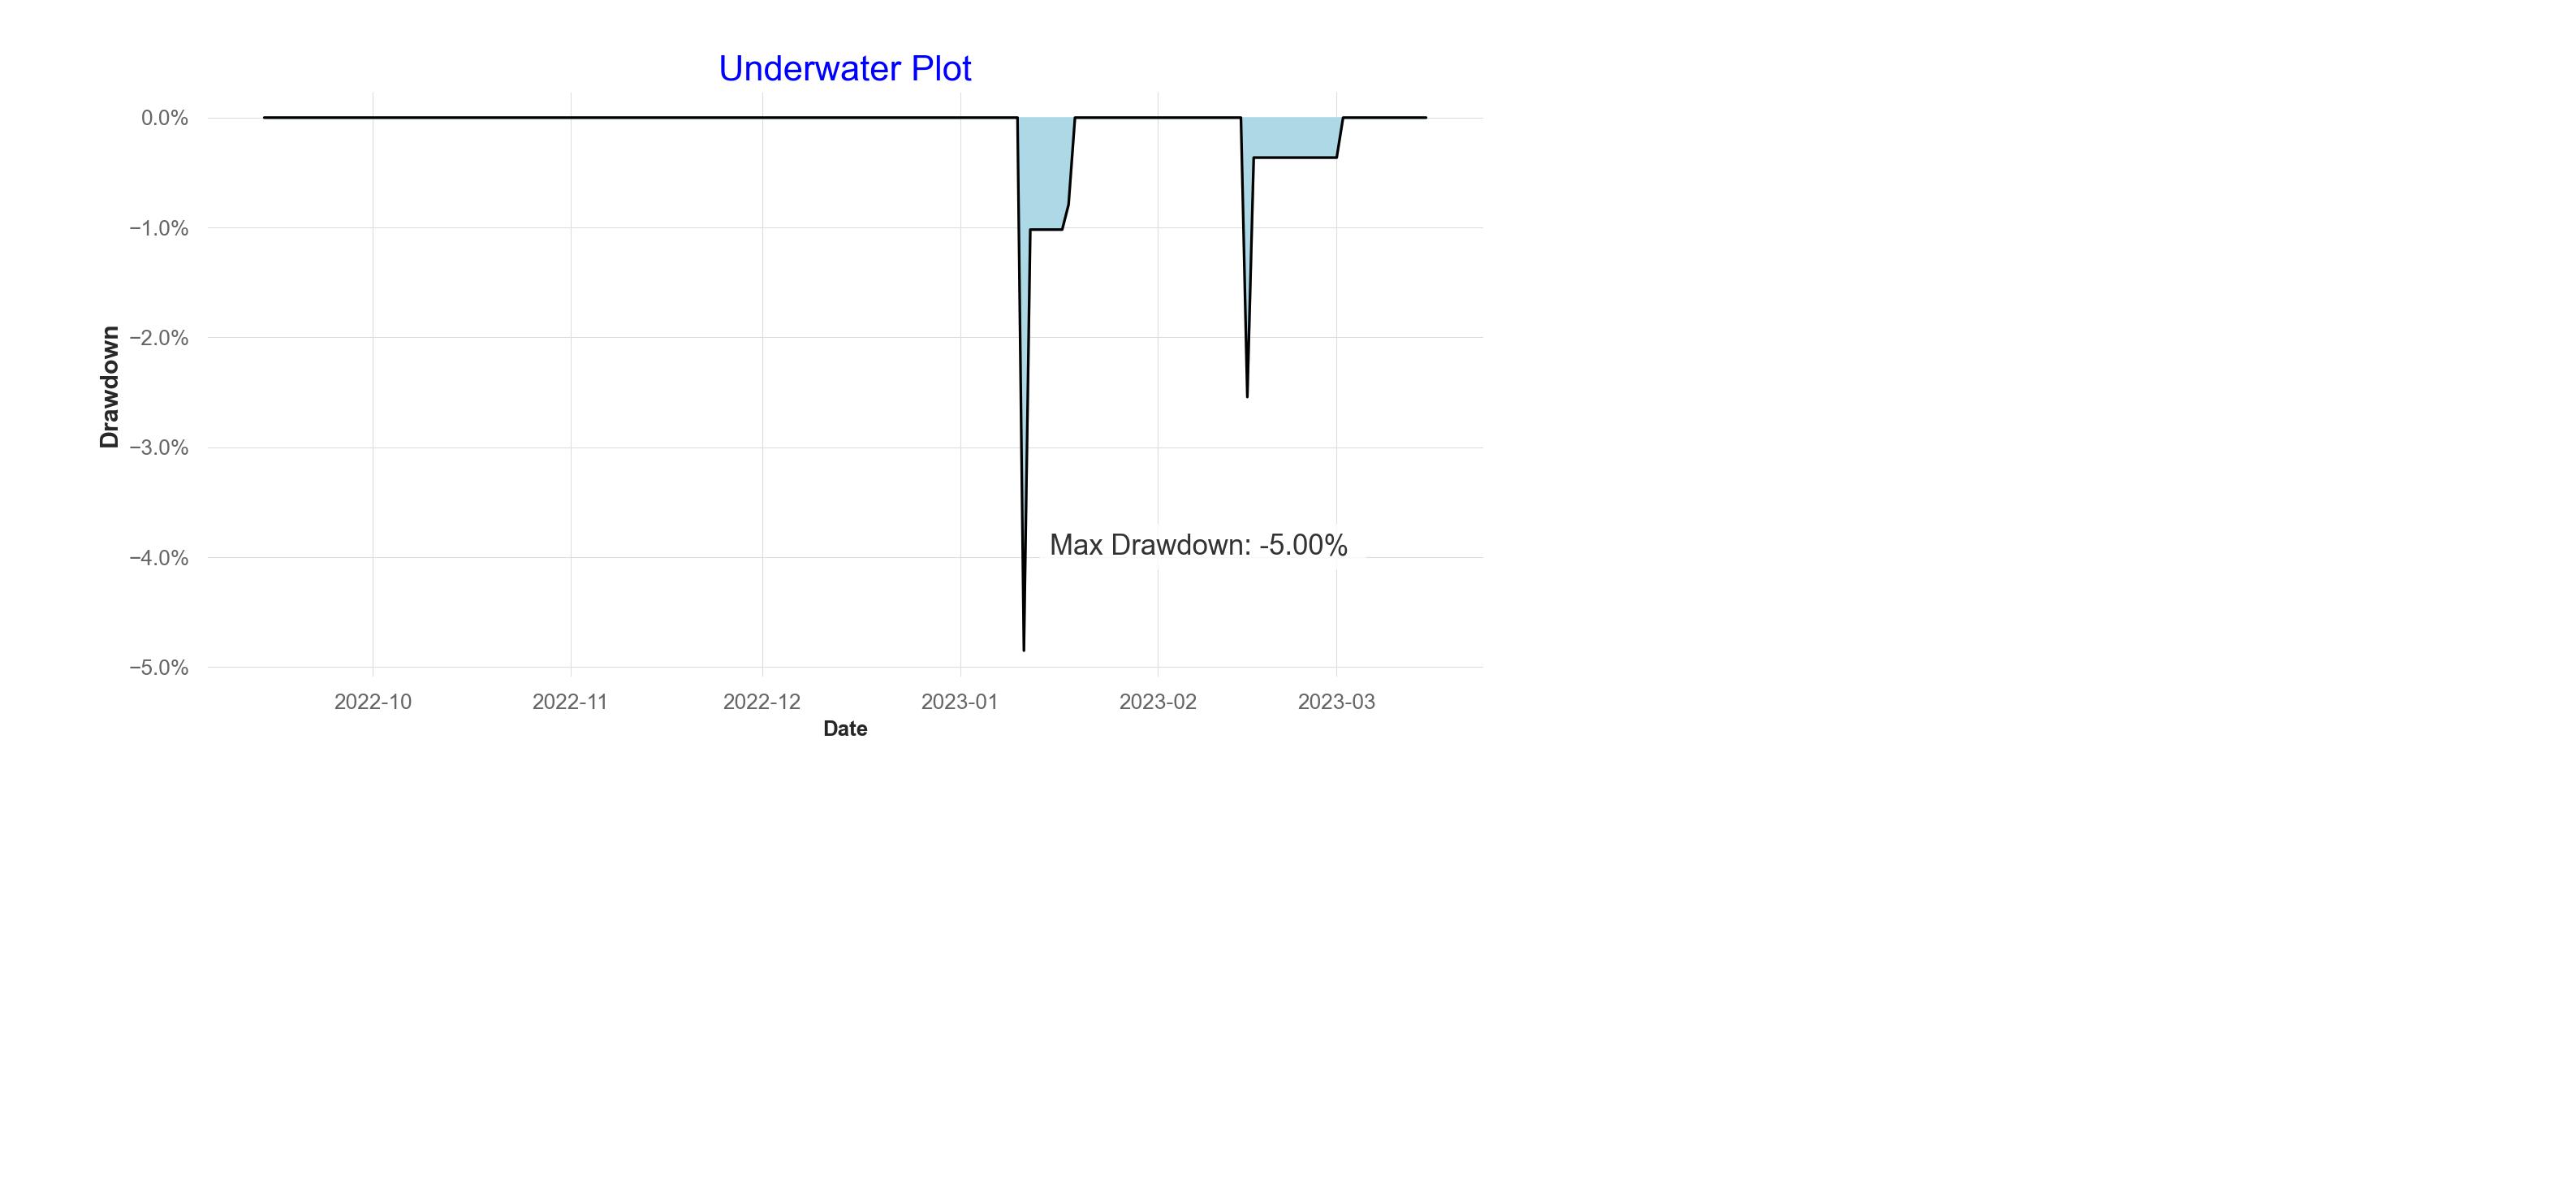

<IPython.core.display.Javascript object>


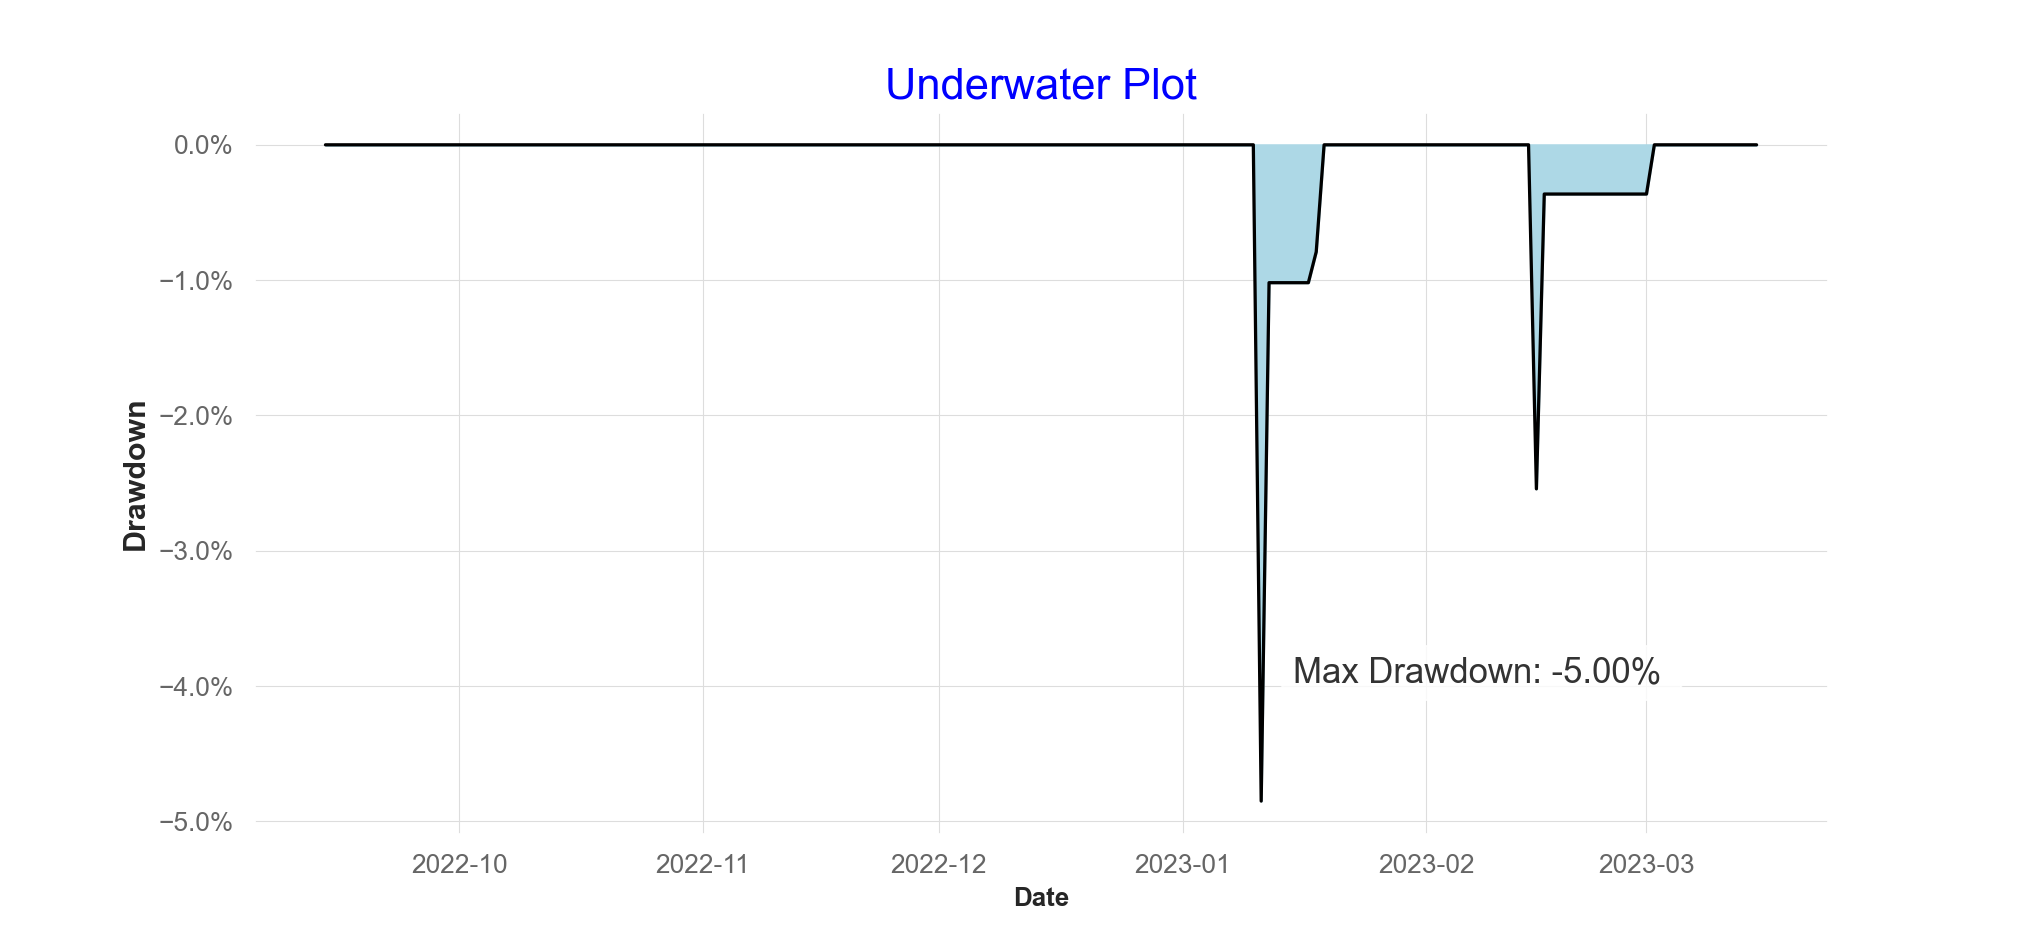

In [43]:
plot_underwater(dd_ser)

In [568]:
#%matplotlib notebook


<IPython.core.display.Javascript object>


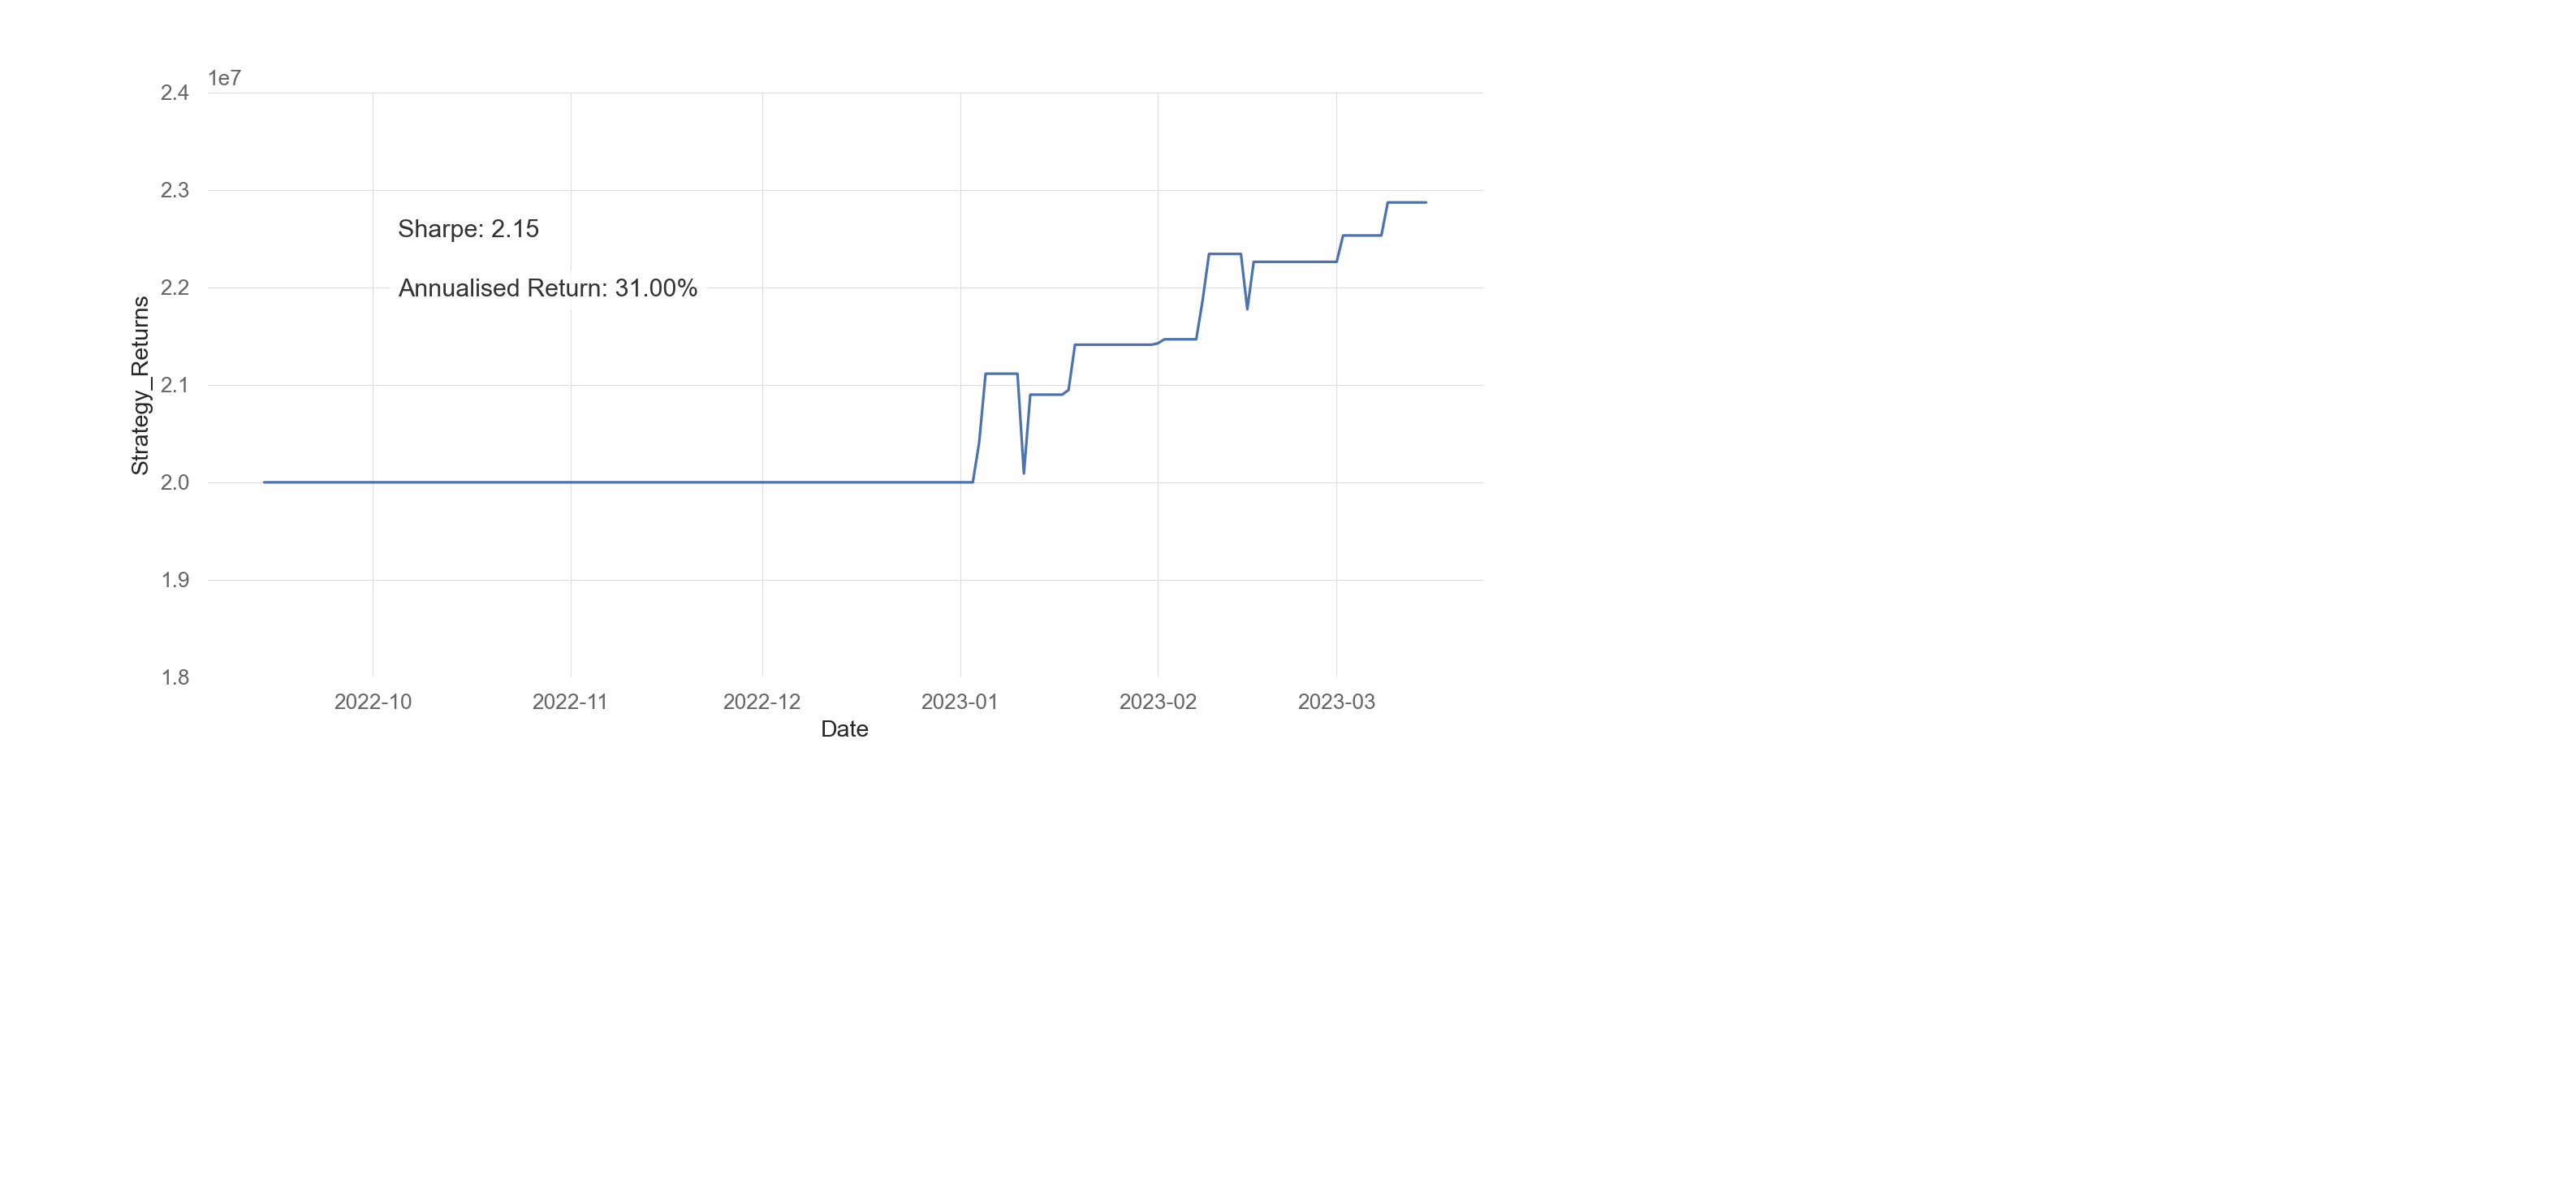

<IPython.core.display.Javascript object>


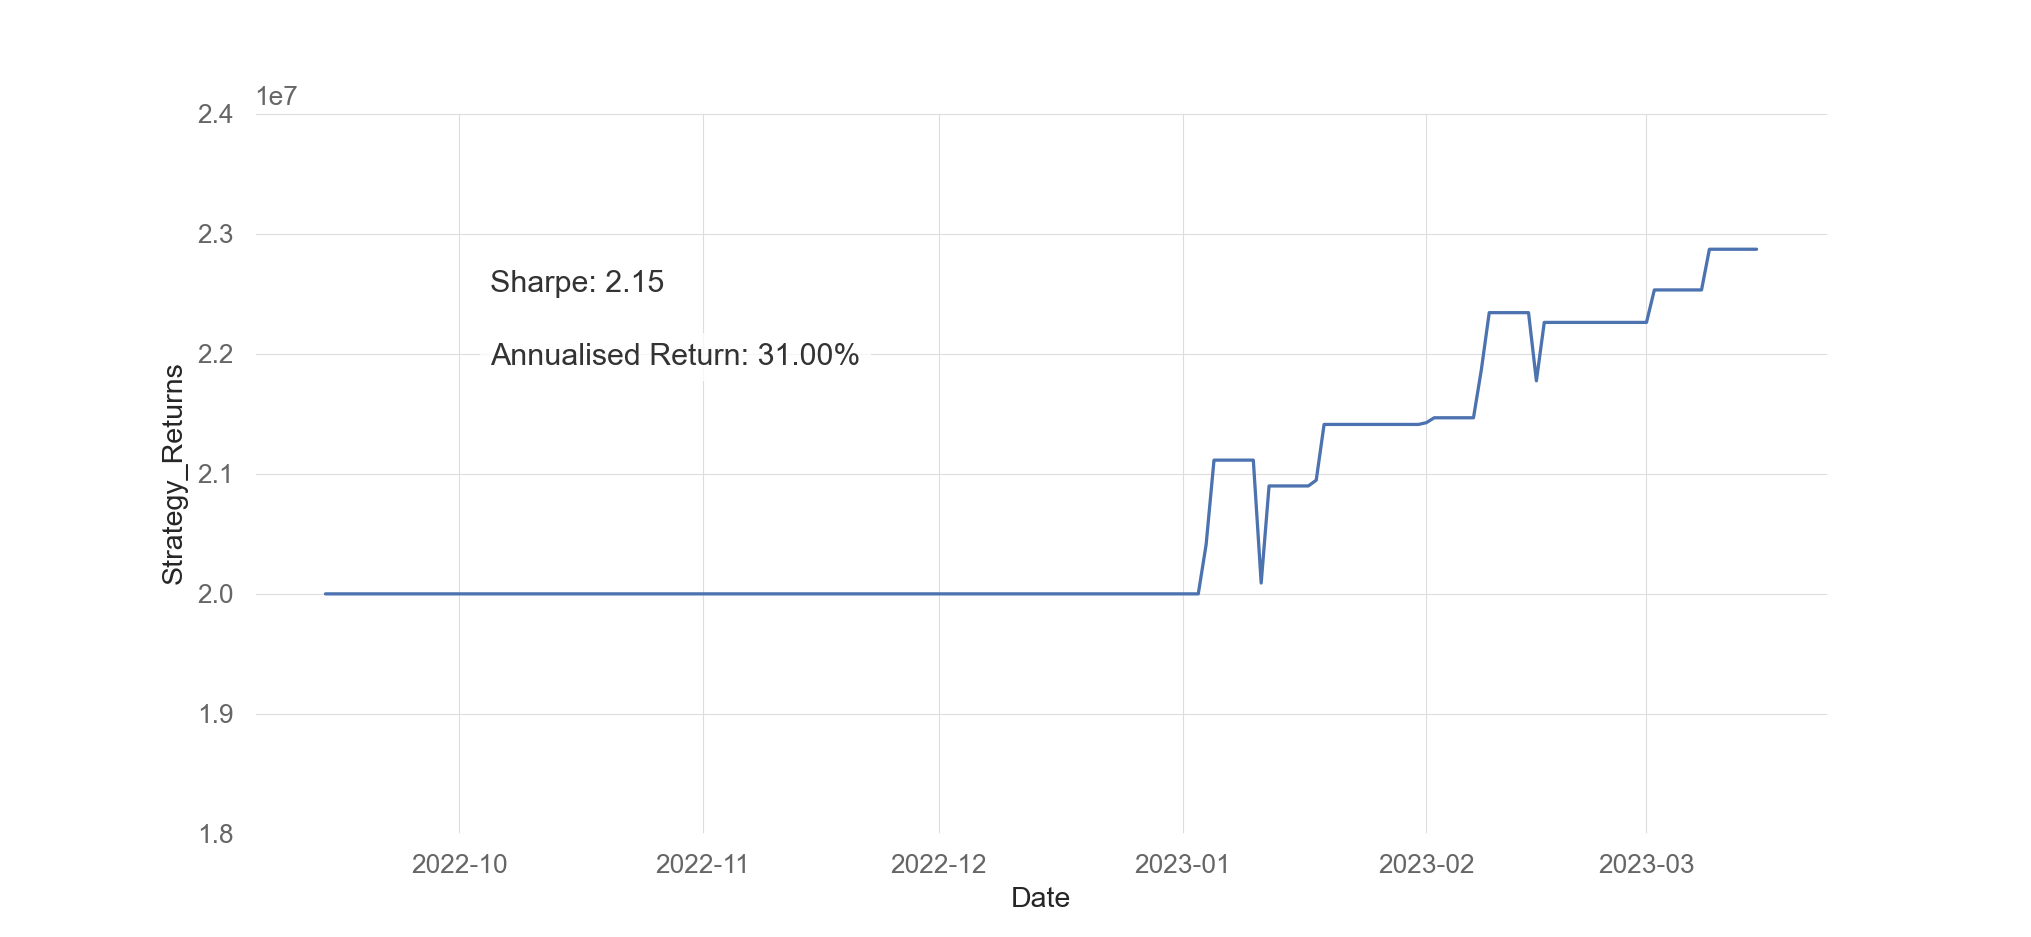

In [44]:
plot_returns(df)

<IPython.core.display.Javascript object>


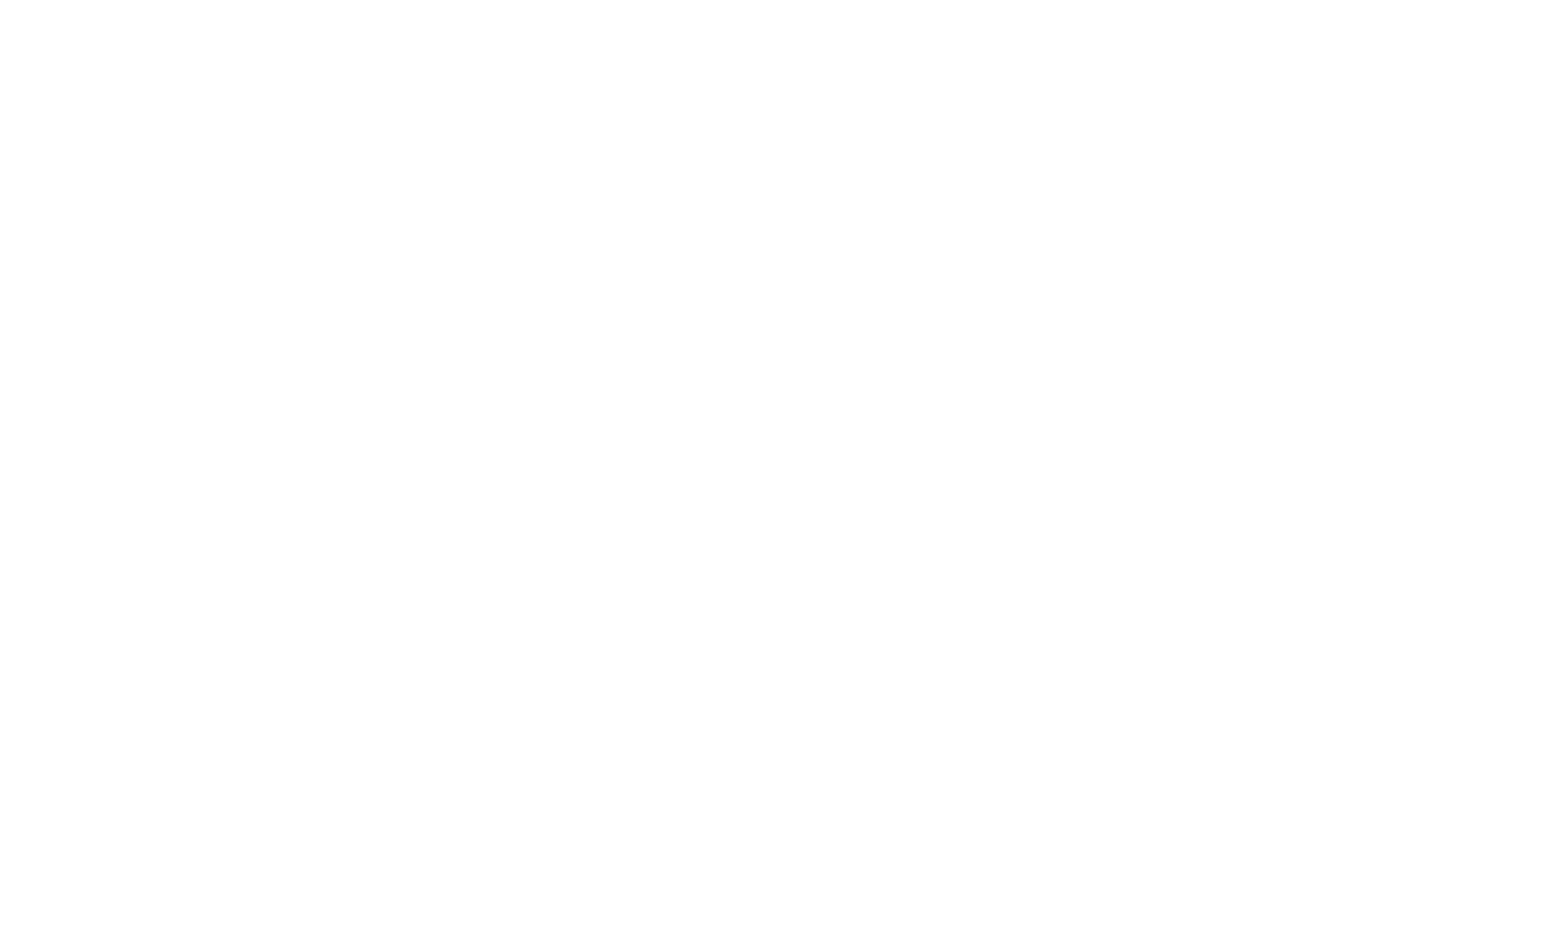

<IPython.core.display.Javascript object>


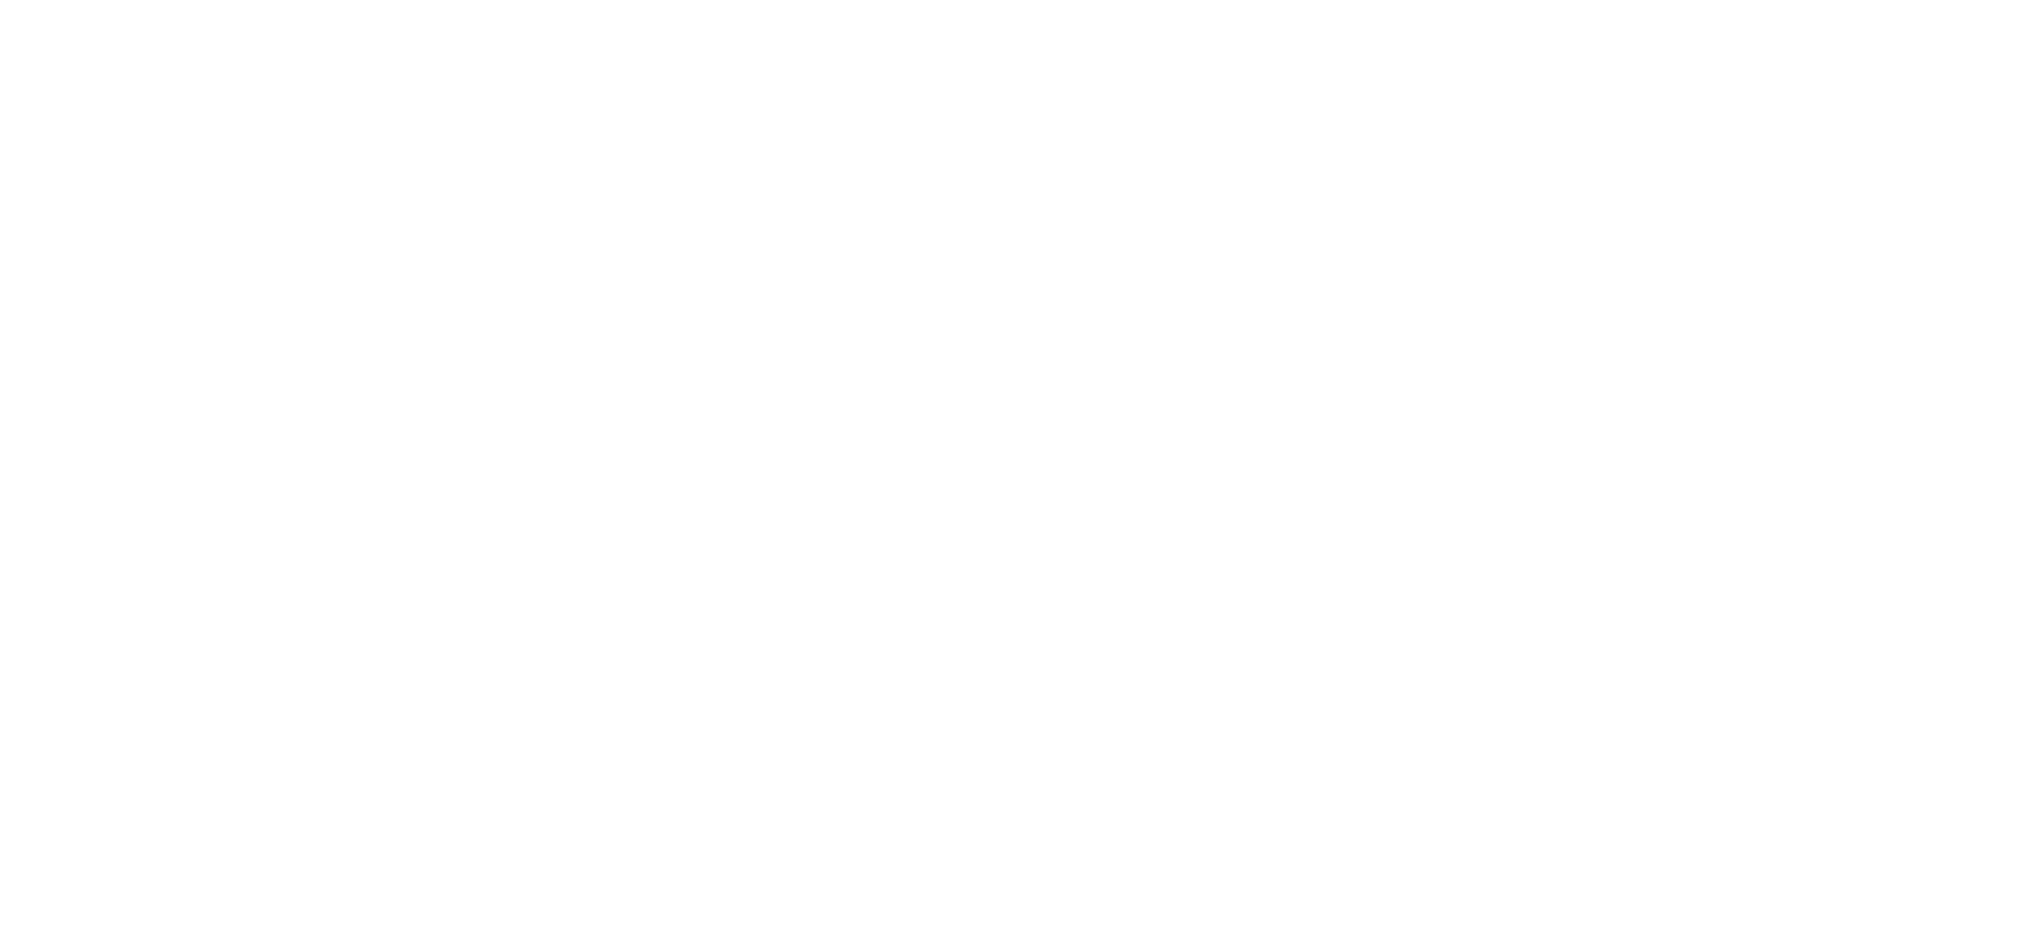

<IPython.core.display.Javascript object>


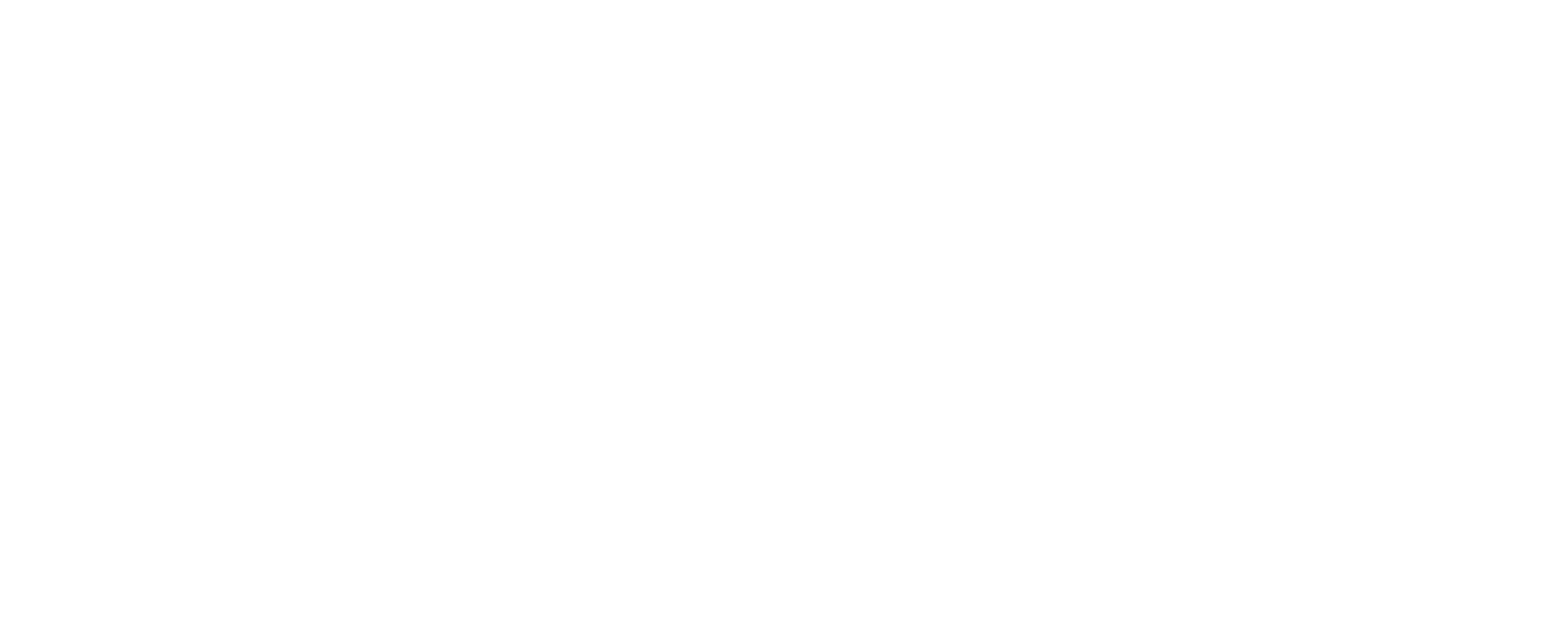

<IPython.core.display.Javascript object>


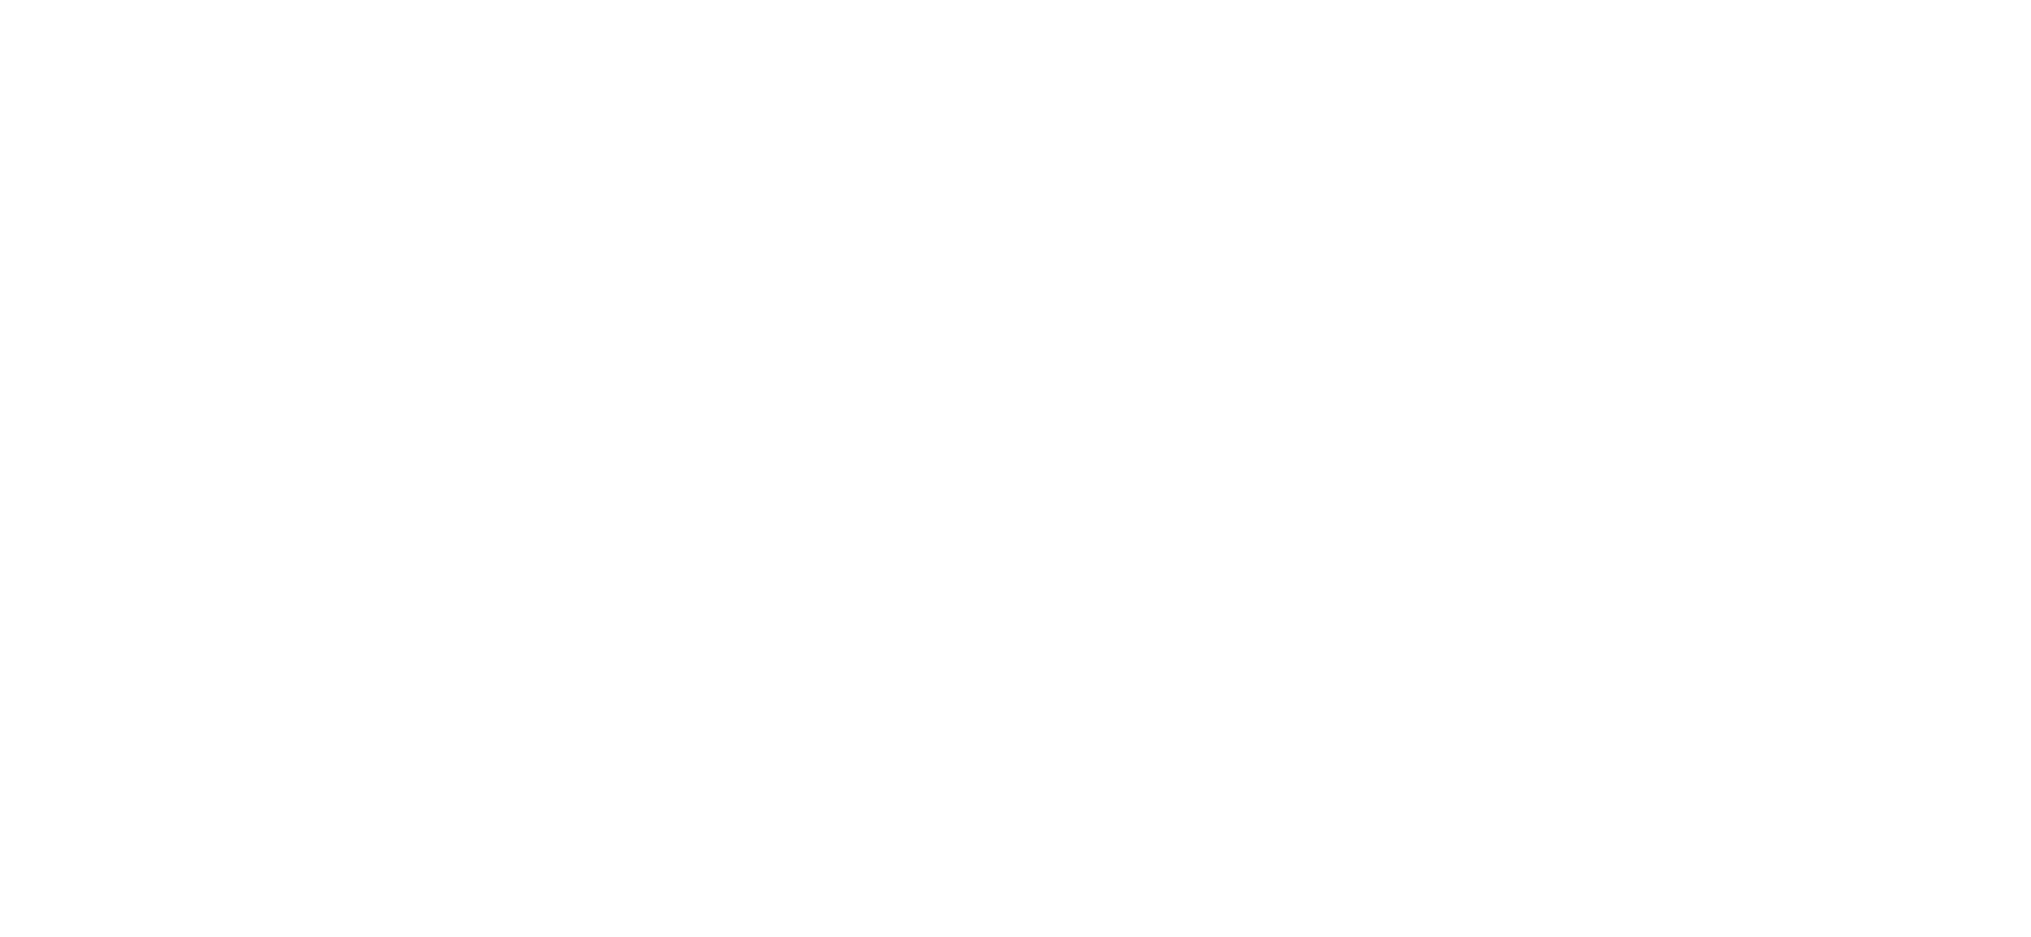

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\aakas\\Desktop\\Aargo\\test\\plots.xlsx'

In [56]:
import openpyxl
from openpyxl.drawing.image import Image



# Create an Excel workbook and sheet
workbook = openpyxl.Workbook()
sheet = workbook.active
plot_returns_path = r"C:\Users\aakas\Desktop\Aargo\test\plot_returns.png"
plot_underwater_path = r"C:\Users\aakas\Desktop\Aargo\test\plot_underwater.png"

# Save the returns plot image
plt.figure(figsize=(10,6))
plot_returns(df)
plt.savefig(plot_returns_path)

# Save the underwater plot image
plt.figure(figsize=(10,4))
plot_underwater(dd_ser)
plt.savefig(plot_underwater_path)

# Insert the images into the Excel sheet
plot_returns_img = Image(plot_returns_path)
plot_underwater_img = Image(plot_underwater_path)
sheet.add_image(plot_returns_img, 'A1')
sheet.add_image(plot_underwater_img, 'A25')

# Save the Excel file
workbook.save(r"C:\Users\aakas\Desktop\Aargo\test\plots.xlsx")

# Close the figure and remove the temporary files
plt.close()
os.remove(plot_returns_path)
os.remove(plot_underwater_path)

<IPython.core.display.Javascript object>


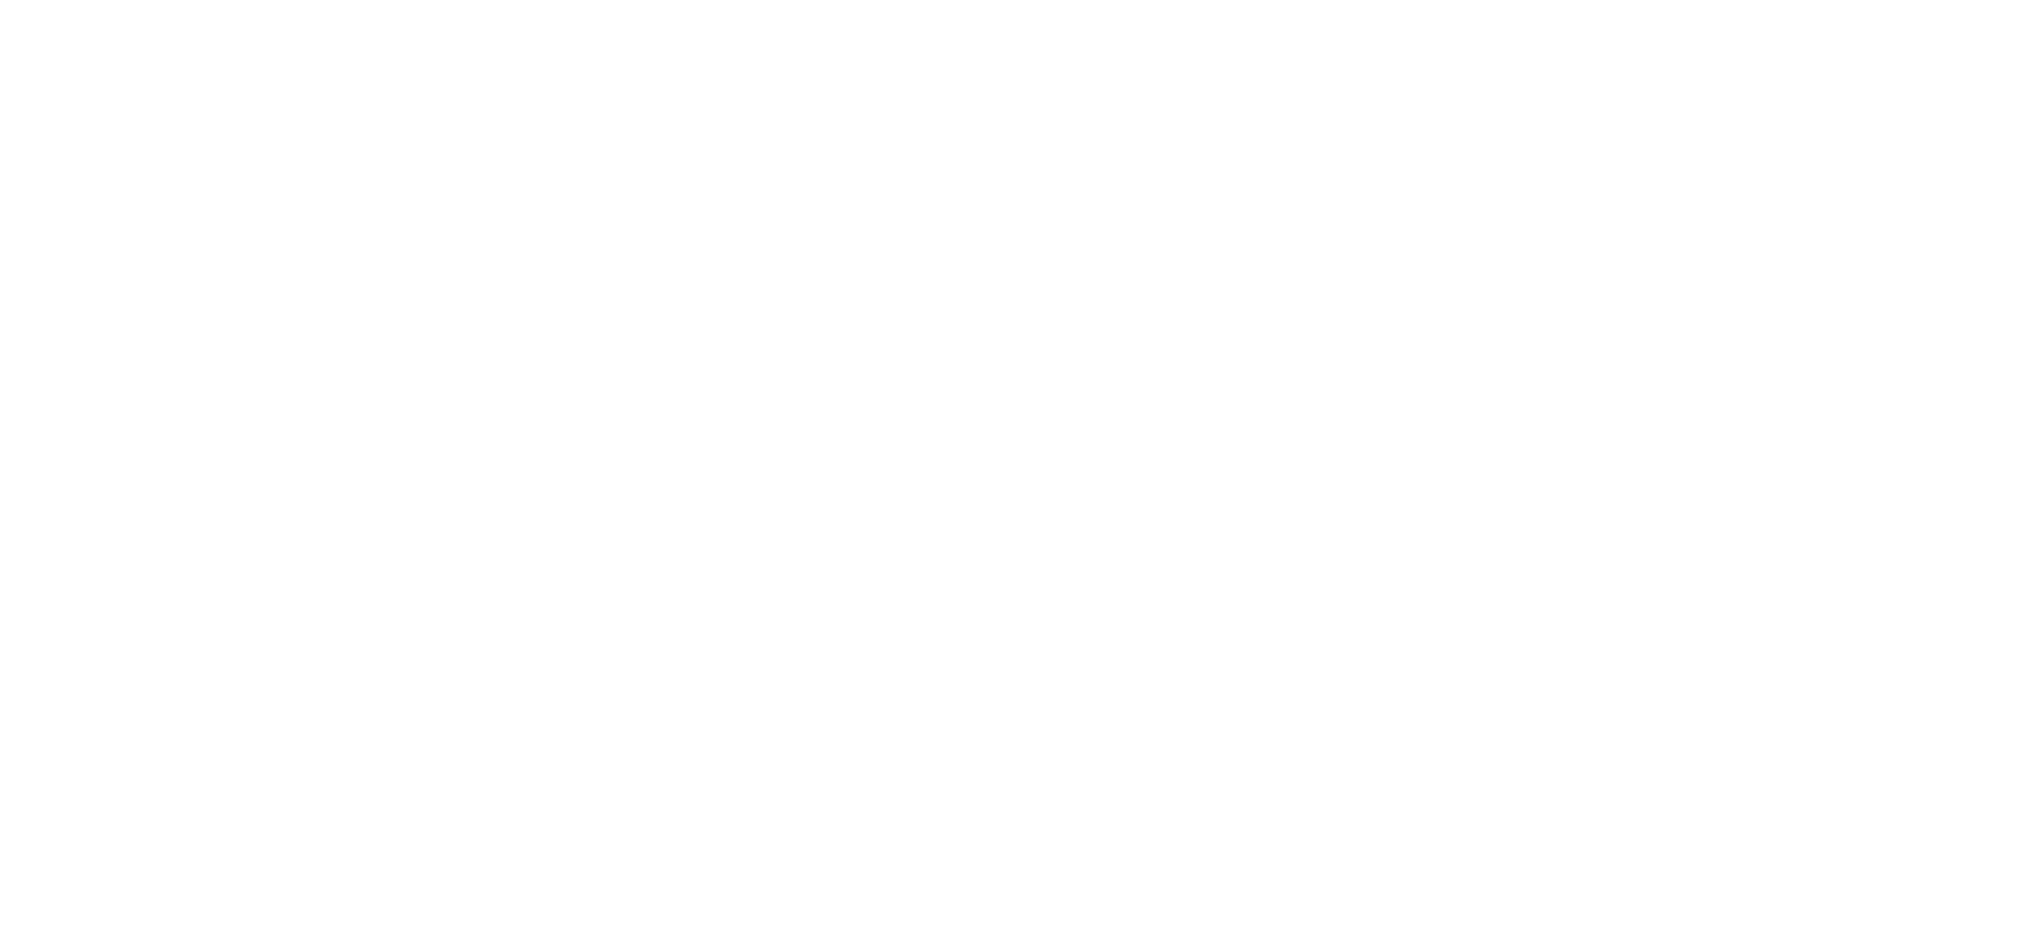

<IPython.core.display.Javascript object>


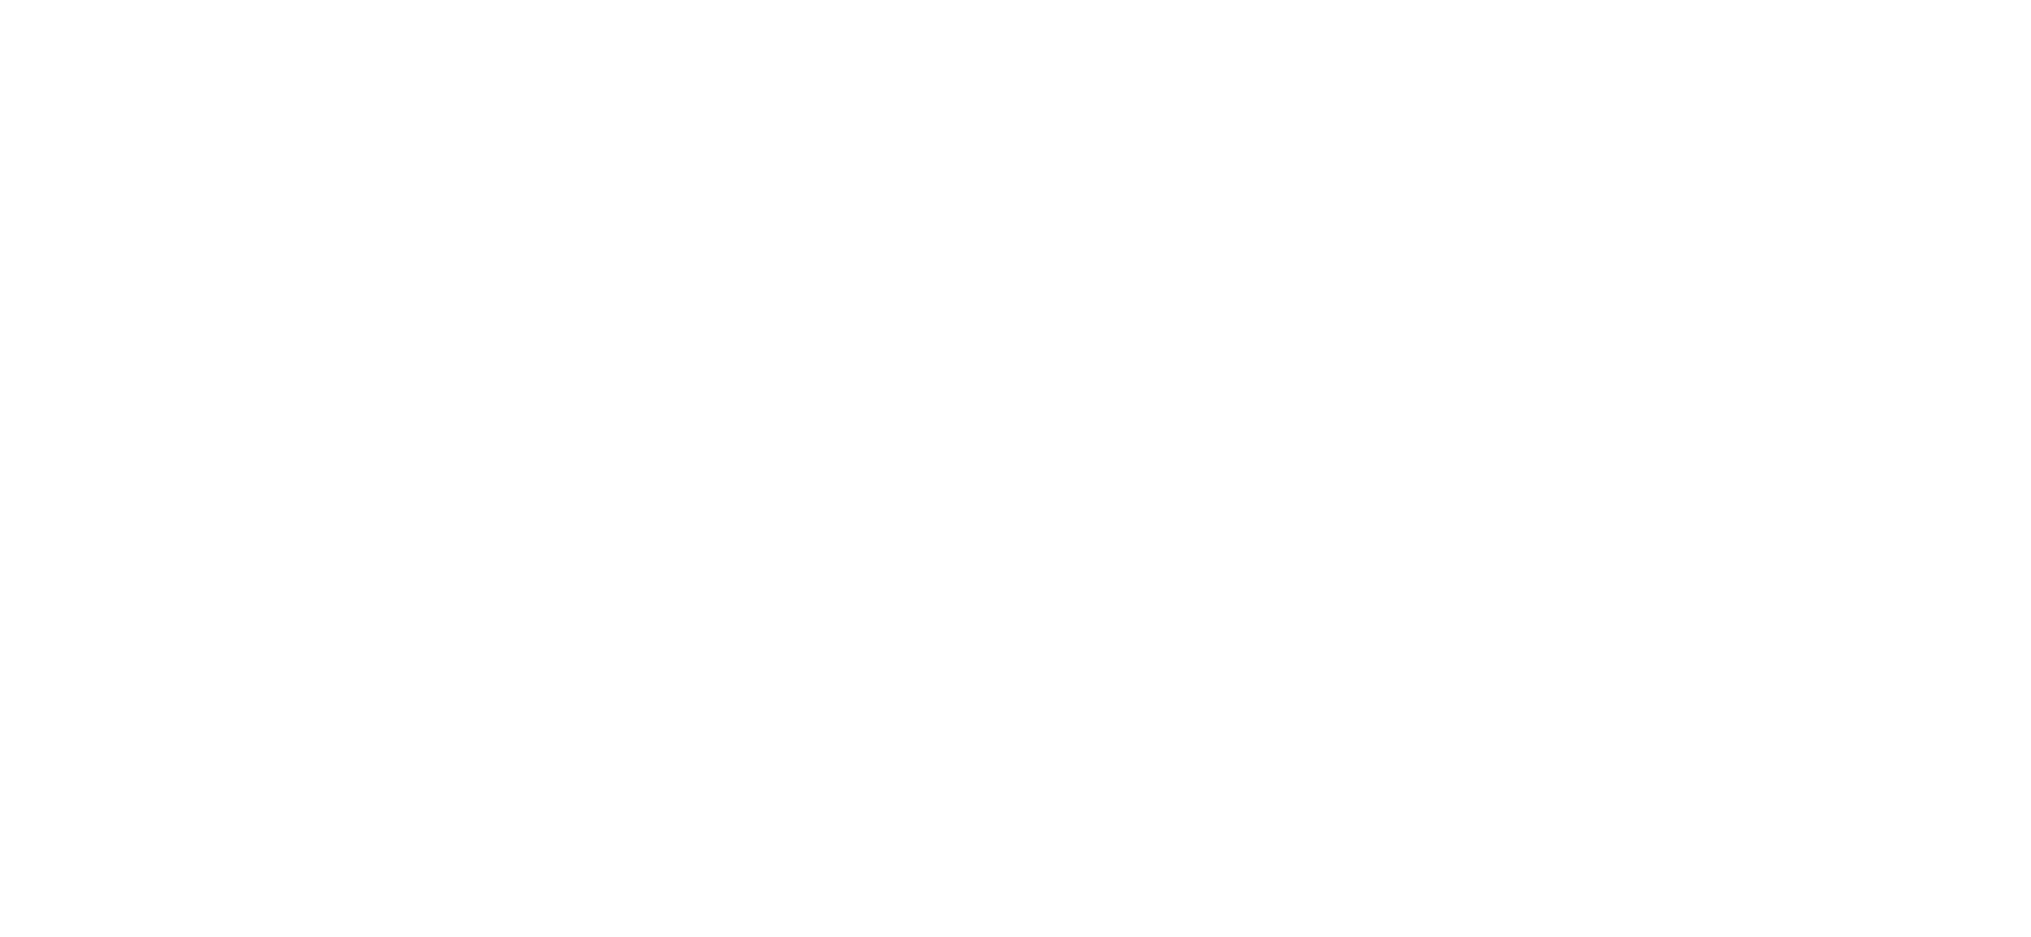

C:\Users\aakas\anaconda3\lib\site-packages\plotly\matplotlylib\mplexporter\exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

C:\Users\aakas\anaconda3\lib\site-packages\plotly\matplotlylib\renderer.py:573: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

C:\Users\aakas\anaconda3\lib\site-packages\quantstats\stats.py:942: UserWarning:

Pandas DataFrame was passed (Series expeted). Only first column will be used.




 
  exp2_bankifty_call_sell
{'Sharpe Ratio': 2.15, 'Sortino Ratio': '3.60', 'Max Drawdown': '-4.85%', 'CAGR': '30.87%', 'Positive months(%)': '100.00', 'Winning days(%)': '86.00', 'Mean_drawdown_time(days)': '11.50'}


C:\Users\aakas\anaconda3\lib\site-packages\quantstats\stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



In [97]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools as tls
from tabulate import tabulate
# Convert the plots to Plotly using mpl_to_plotly

underwater_fig = plot_underwater(dd_ser)
returns_fig = plot_returns(df)

underwater_plotly = tls.mpl_to_plotly(underwater_fig)
returns_plotly = tls.mpl_to_plotly(returns_fig)

# Convert the Plotly plots to HTML
underwater_html = plotly.offline.plot(underwater_plotly, output_type='div')
returns_html = plotly.offline.plot(returns_plotly, output_type='div')

stg_name = os.path.basename(os.path.dirname(sel_df))

print("\n \n " , stg_name)


#==== Metrics to display... 

vars_dict = {'Sharpe Ratio': round(sharpe_ratio(df)[0] , 2),
             'Sortino Ratio' : format(adjusted_sortino(df.pct_change() , 0), '.2f'),
             'Max Drawdown': format(max_dd(df)[0]*100, '.2f') + '%',
             'CAGR': format(qs.stats.cagr(df)[0]*100, '.2f') + '%',
             'Positive months(%)': format(positive_months(df), '.2f'),
             'Winning days(%)': format(winning_days(df.pct_change()), '.2f'), 
             'Mean_drawdown_time(days)': format(mean_recovery_time(df), '.2f')}

print(vars_dict)

vars_df = pd.DataFrame(vars_dict.items(), columns=['Variable', 'Value'] )
vars_html = vars_df.to_html(index=False, header=None, border=2, justify='center' )

#-- drawdown details

# Convert the "qq" dataframe to an HTML table
dds = biggest_drawdowns(df)
qq_html = dds.to_html(index=False, border=2, justify='center' )


html = f'''
<html>
<head>
<style>
.my-table td {{
    font-family: Arial, Helvetica, sans-serif;
    font-size: 12px;
    padding: 5px 20px;
}}
.plot-container {{
    height: auto;
    width: auto;
    justify-content: space-between;
    
}}
.half-container {{
    height: auto;
    width: 100%;
    justify-content: space-between;
    padding: 1px;
    margin-bottom:-30px;
}}
.half-flex-container {{
    display: flex;
    justify-content: space-between;
    height: auto;
    padding: 1px;
    width: 100%;
    margin-bottom: auto;
}}
.half-flex-container > div {{
    width: auto;
    margin-right: auto;
    padding: 1px;
    box-sizing: border-box;
}}
.returns-plot {{
    height: auto;
    width: auto;
    padding: 1px;
    font-size: 14px;
    box-sizing: border-box;
}}
.performance-metrics {{
    height: auto;
    width: auto;
    font-family: Arial, sans-serif;
    font-size: 14px;
    justify-content: space-between;
}}
.underwater-plot {{
    height: auto;
    width: auto;
    box-sizing: border-box;
    font-size: 14px;
    padding: 1px;
    
}}
h1 {{
  text-align: center;
}}


</style>
</head>
<body>
<h1>Strategy Performance Report - {stg_name} </h1>

<!-- Add the following div to display the returns plot and performance metrics side by side -->
<div class="half-container">
    <div class="half-flex-container">
        <div class="returns-plot">
            <h2 style="text-align: center;">Returns Plot</h2>
            {returns_html}
        </div>

        <!-- Add the following div to display performance metrics on the right side of the returns plot -->
        <div class="performance-metrics">
            <h2 style="text-align: center;">Performance Metrics</h2>
            {vars_html}
        </div>
    </div>
</div>


<!-- Add the following div to display the underwater plot and drawdown details side by side -->
<div class="half-container">
    <div class="half-flex-container">
        <div class="underwater-plot">
            <h2 style="text-align: center;">Underwater Plot</h2>
            {underwater_html}
        </div>

        <!-- Add the following div to display drawdown details on the right side of the underwater plot -->
        <div class="performance-metrics">
            <h2 style="text-align: center;">Drawdown Details</h2>
            {qq_html}
        </div>
    </div>
</div>


</body>
</html>
'''


# Save the HTML report to a file
with open(r"C:\Users\aakas\Desktop\Aargo\test\plots.html", 'w' , encoding='utf-8') as f:
    f.write(html)